In [1]:
from cyvcf2 import VCF, Writer
import sys
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append(str(Path().resolve().parents[2] / "src" / "python"))
from paths import data_path, training_path

In [2]:
# Input VCFs
mutect2_vcf_path = data_path / "GIAB/hg38_called/HG008_variants.combined.vcf"
golden_vcf_path = data_path / "GIAB/hg38_called/HG008-T--HG008-N.snv.indel.high_confidence.v7.annotated.vcf"
output_vcf_path = training_path / "annotated_hg38.vcf"

In [3]:
# Load golden variants into a set of (chrom, pos, ref, alt)
golden_variants = set()
for variant in VCF(golden_vcf_path.as_posix()):
    for alt in variant.ALT:
        golden_variants.add((variant.CHROM, variant.POS, variant.REF, alt))

In [4]:
# Open Mutect2 VCF and add new INFO field definition
mutect2_vcf = VCF(mutect2_vcf_path)
mutect2_vcf.add_info_to_header({
    'ID': 'GOLDEN',
    'Description': 'Variant is present in golden list',
    'Type': 'Flag',
    'Number': 0
})

0

In [5]:
writer = Writer(output_vcf_path, mutect2_vcf)

In [6]:
# used for barplots
golden_count = 0
not_golden_count = 0

In [7]:
# Annotate and write variants
for variant in mutect2_vcf:
    is_in_golden = any((variant.CHROM, variant.POS, variant.REF, alt) in golden_variants for alt in variant.ALT)
    if is_in_golden:
        variant.INFO['GOLDEN'] = True
        golden_count += 1
    else:
        not_golden_count += 1
    writer.write_record(variant)

In [8]:
# Clean up
writer.close()
mutect2_vcf.close()

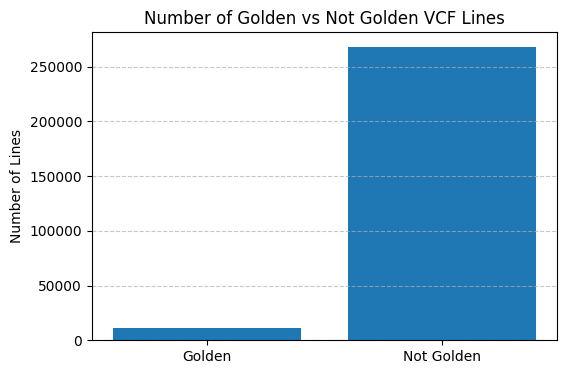

In [9]:
labels = ['Golden', 'Not Golden']
counts = [golden_count, not_golden_count]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.title('Number of Golden vs Not Golden VCF Lines')
plt.ylabel('Number of Lines')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()